In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from dataset import *
from save_load import *
from NN_library.PINN.PINN import *
from NN_library.VPINN.train_VPINN import *
from NN_library.PINN.train_PINN import PDE_loss
from utility import *
%load_ext autoreload
%autoreload 2

In [3]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

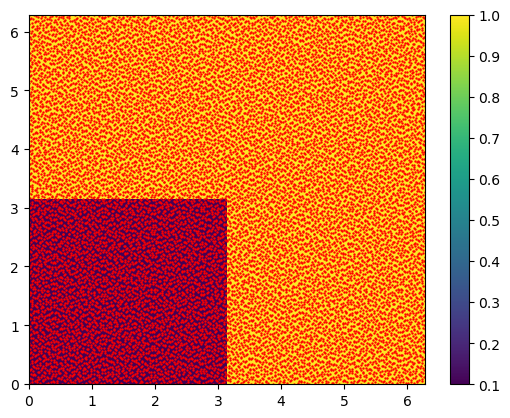

In [4]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x<np.pi)&(y<np.pi), 0.1, 1)
    return a

def A_interp(x):  
    eps = torch.pi / 1e1
    x_dir = 0.5 * (torch.clamp(torch.sin(x[:,0]), -eps, eps) + eps) / eps
    y_dir = 0.5 * (torch.clamp(torch.sin(x[:,1]), -eps, eps) + eps) / eps
    a = 0.1 + 0.9*(1 - x_dir * y_dir).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A(x):  
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.5, c='r')

In [5]:
def eig_func(x, m, n):
    z = torch.sin(m*x[:,0])*torch.sin(n*x[:,1])
    return z

N_test = 7
test_functions = []
G = torch.eye(N_test**2,device=dev)

for m in range(N_test):
    for n in range(N_test):
        test_functions.append(lambda x, m=m+1, n=n+1: eig_func(x, m, n))
        G[m*N_test+n, m*N_test+n] = 1/((m+1)**2+(n+1)**2)

In [ ]:
fig, axs = plt.subplots(nrows=N_test, ncols=N_test, figsize=(N_test, N_test), dpi=150)
for i in range(N_test**2):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu())
    axs.flat[i].set_axis_off()

In [40]:
net_H1 = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_H1.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 10000, 'dev' : dev, 'name' : f'NN_library/VPINN/VPINN_H1_{total_params}'}

Using device: cuda
Number of parameters: 66


In [38]:
net_H1 = load_network(net_H1, args['name']+'_9999', args)
net_H1 = net_H1.to(dev)

In [39]:
losses_train = train(net_H1, loaders, args, A, H1, test_functions, G, L)

Epoch: 0 mean train loss:  3.99028686e-05
Epoch: 1 mean train loss:  4.16430121e-05
Epoch: 2 mean train loss:  4.00401841e-05
Epoch: 3 mean train loss:  4.02647784e-05
Epoch: 4 mean train loss:  4.08639644e-05
Epoch: 5 mean train loss:  4.06148029e-05
Epoch: 6 mean train loss:  4.00956342e-05
Epoch: 7 mean train loss:  3.99142300e-05
Epoch: 8 mean train loss:  4.01286634e-05
Epoch: 9 mean train loss:  4.03611702e-05
Epoch: 10 mean train loss:  4.03271042e-05
Epoch: 11 mean train loss:  4.01011202e-05
Epoch: 12 mean train loss:  3.99240089e-05
Epoch: 13 mean train loss:  3.99355995e-05
Epoch: 14 mean train loss:  4.00683493e-05
Epoch: 15 mean train loss:  4.01533907e-05
Epoch: 16 mean train loss:  4.01048746e-05
Epoch: 17 mean train loss:  3.99821874e-05
Epoch: 18 mean train loss:  3.99040800e-05
Epoch: 19 mean train loss:  3.99271485e-05
Epoch: 20 mean train loss:  4.00022618e-05
Epoch: 21 mean train loss:  4.00386452e-05
Epoch: 22 mean train loss:  4.00008466e-05
Epoch: 23 mean train 

KeyboardInterrupt: 

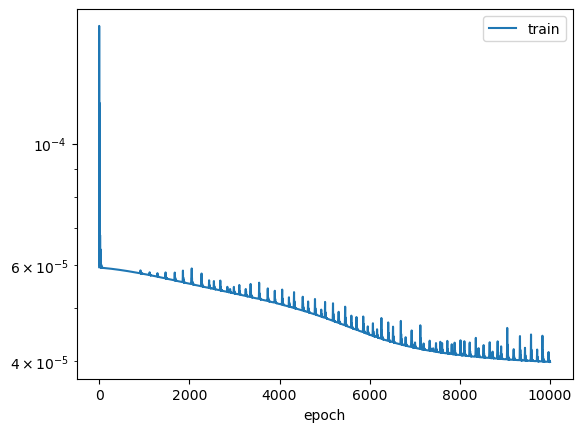

In [30]:
plt.plot(losses_train)
plt.xlabel('epoch')
plt.legend(['train'])
plt.yscale('log')

In [20]:
np.save(f'NN_library/training_data/VPINN_H1_{total_params}_1', np.array(losses_train))

In [31]:
U1 = net_H1(grid_data).detach().cpu()
error_1 = PDE_loss(grid_data, net_H1, A, H1).detach().cpu()

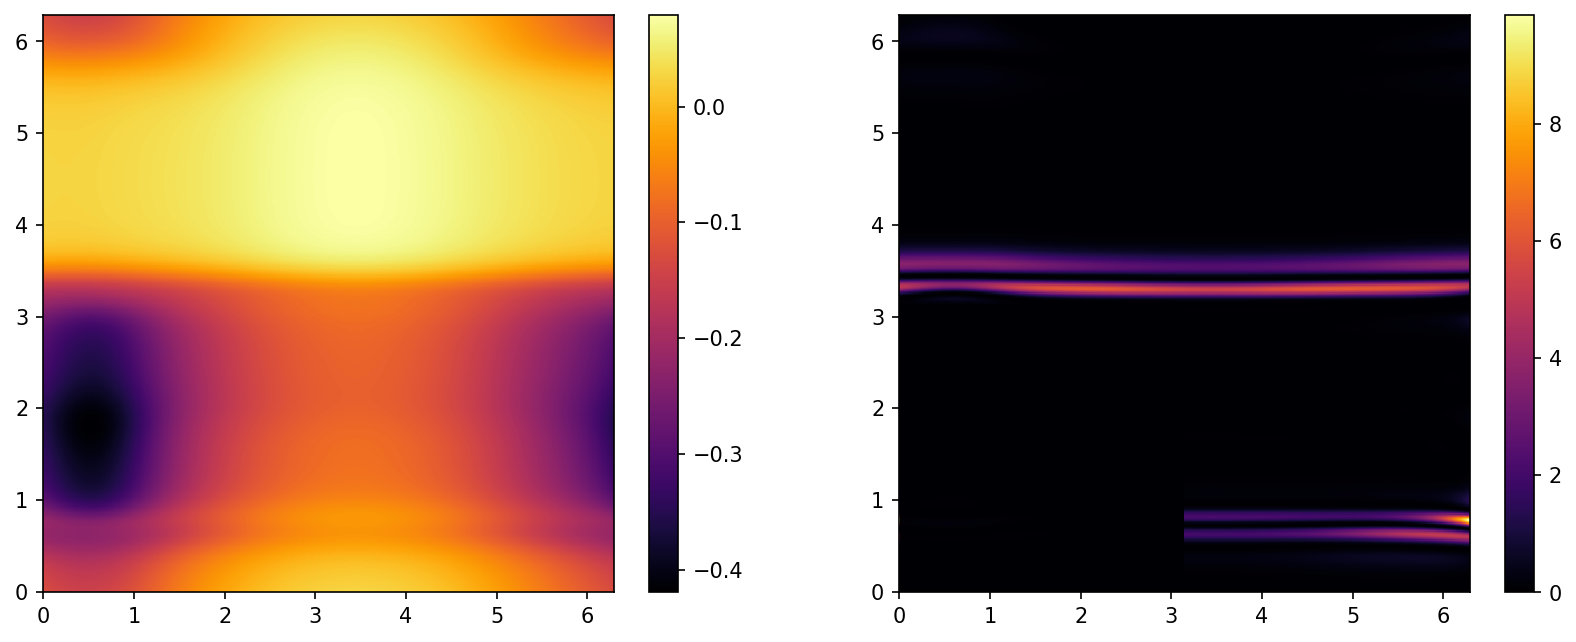

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13.5,5), dpi=150)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])

In [33]:
inputs = data[:].to(dev).requires_grad_(True)
T1 = net_H1(inputs)
dq1 = torch.autograd.grad(
            outputs=T1, inputs=inputs,
            grad_outputs=torch.ones_like(T1)
    )[0].detach()
triang = Triangulation(data[:,0], data[:,1])
n_elem = len(triang.triangles)

In [24]:
A_bound = compute_bound(T1, dq1, triang, inputs, A, H1, L)
print(A_bound[0])
print(A_bound[1])

[[0.76415069]
 [0.00258551]]
[[0.75436413]
 [0.00320191]]


In [34]:
A_avg = compute_avg(dq1, inputs, A, H1, L)
print(A_avg)

[0.7601342  0.00717279]
